# Backtest Trading Simulator
### Imports

In [1]:
import sys
import numpy as np
import copy as cp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import date
sys.path.insert(1, '../app')
sys.path.insert(2, '../src')

from markets import Market
from brokers import Broker
from traders import Trader
from utils import market_plot, profit_and_portfolio_value, profits, portfolio_values, liquids, fees_and_tax
from utils import clean_string, delete_figure_agg, draw_figure

### Simulator function

In [2]:
def simulator(liquid, tickers, periods, ratios, sell_strategy, start_date, end_date, buy_fee,
              min_buy_fee, sell_fee, min_sell_fee, tax, verbose, plots_normalize):

    traders_list = []
    market = Market(tickers, start_date=start_date, end_date=end_date)
    broker = Broker(buy_fee=buy_fee, min_buy_fee=min_buy_fee, sell_fee=sell_fee,
                    min_sell_fee=min_sell_fee, tax=tax, my_market=market)
    first_date = cp.copy(market.current_date)

    for i, period in enumerate(periods):
        print(f'period: {period}')

        # init market
        market.current_idx = 0
        market.current_date = first_date

        # init new trader
        trader = Trader(liquid=liquid, balance_period=period, broker=broker, market=market,
                        verbose=verbose, sell_strategy=sell_strategy)

        # buy some stocks
        for ticker in tickers:
            trader.buy(ticker, 1)

        done = False
        steps = 0

        trader.balance(tickers, p=ratios)
        while not done:
            steps += 1
            if steps % 100 == 0:
                print('| Step: {:6.0f} / {:6.0f} | Balance period: {:4.0f} |'
                      .format(steps, market.steps, trader.balance_period))
            # step market forward in time
            done, previous_date = market.step()

            # step trader forward in time
            trader.step(previous_date)

            # balance trader portfolio
            if steps % trader.balance_period == 0:
                trader.balance(tickers, p=ratios)

        traders_list.append(trader)

    # plot results
    market_plot(market, normalize=plots_normalize)
    profit_and_portfolio_value(traders_list, periods, 'balance period')
    fees_and_tax(traders_list, periods, 'balance period')
    return traders_list, market

### Fill in the simulation arguments

In [3]:
# Arguments
liquid = 100000                             # USD
tickers = ['AAPL', 'GOOG', 'SPY', 'ORCL']   #
periods = [2, 4, 8]                         # days
ratios = [0.25, 0.25, 0.25, 0.25]           # adds up to 1
sell_strategy = 'FIFO'                      # ['LIFO', 'FIFO', 'TAX_OPT']
start_date = (2020, 1, 1)                   # tuple(yyyy, m, d)
end_date = (2021, 1, 1)                     # tuple(yyyy, m, d)
buy_fee = 0.08                              # %
min_buy_fee = 2                             # USD
sell_fee = 0.08                             # %
min_sell_fee = 2                            # USD
tax = 25.                                   # %
verbose = False                              # [True, False]
plots_normalize = False                     # [True, False]

### Run

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
period: 2
| Step:    100 /    254 | Balance period:    2 |
| Step:    200 /    254 | Balance period:    2 |
period: 4
| Step:    100 /    254 | Balance period:    4 |
| Step:    200 /    254 | Balance period:    4 |
period: 8
| Step:    100 /    254 | Balance period:    8 |
| Step:    200 /    254 | Balance period:    8 |


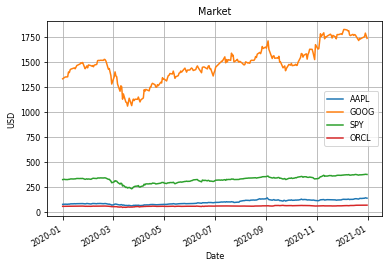

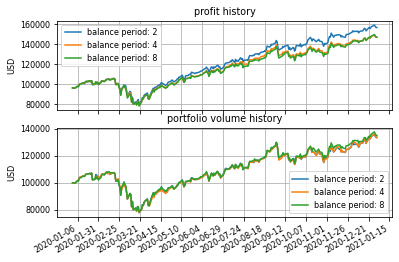

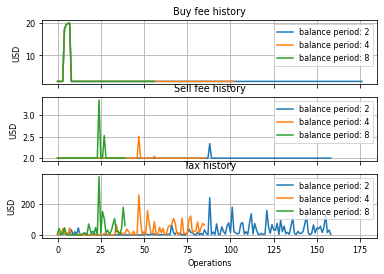

In [4]:
# run the simulation
traders_list, market = simulator(liquid, tickers, periods, ratios, sell_strategy, start_date, end_date,
                                 buy_fee, min_buy_fee, sell_fee, min_sell_fee, tax, verbose, plots_normalize)

In [7]:
def plot_index(market: Market):
    index_return_percent = market.index_return_percent

    interval = np.int(len(market.index_return_percent) / 10)
    fig = plt.figure(dpi=200)
    ax = fig.add_subplot()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=interval))
    ax.set_title('Market Index')
    ax.plot(market.index_data.index.to_numpy(), index_return_percent, label='S&P 500')
    ax.legend()
    ax.set_xlabel('Date')
    ax.set_ylabel('[%]')
    fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')
    ax.grid()
    plt.show()

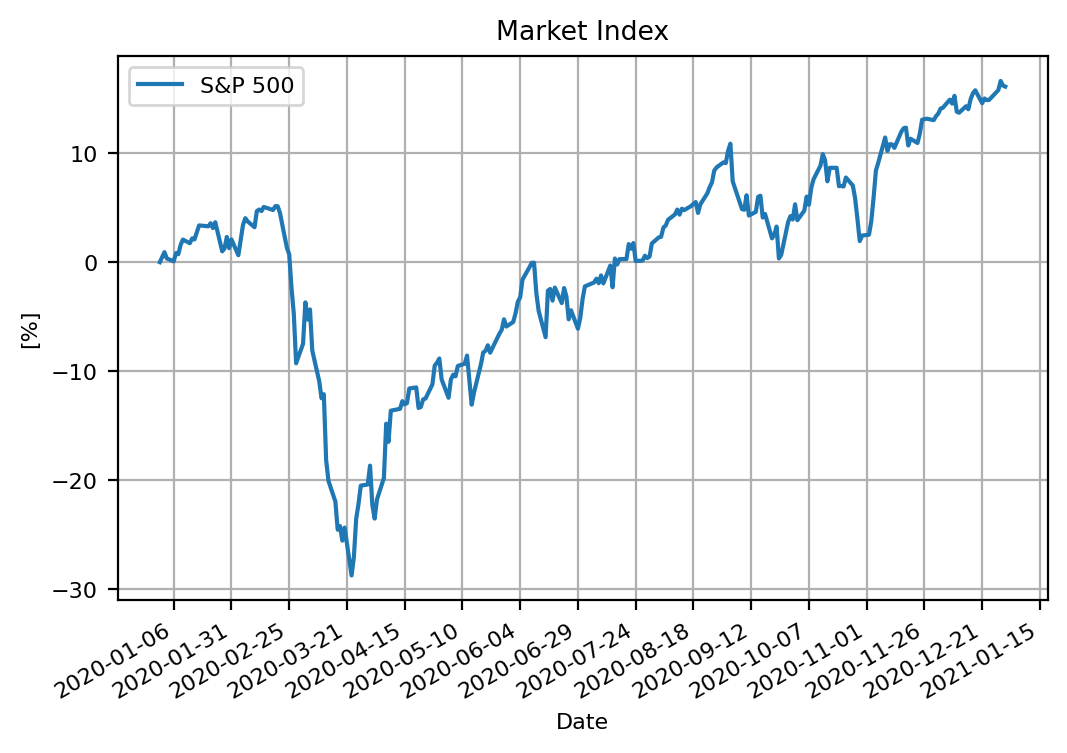

In [8]:
plot_index(market)